In this notebook we use GCN to analyze the POIs networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys
import random

In [ ]:
random.seed(10)

In [ ]:
df = pd.read_csv('./datasets/nyc_label.csv')

In [ ]:
df.tail(10)

,Unnamed: 0,Label (Grouping)_x,Own children of the householder under 6 years,Own children of the householder 6 to 17 years,Mean travel time to work (minutes),Median household income (dollars),Mean household income (dollars),Total housing units,Homeowner vacancy rate,Rental vacancy rate,...,geoid,typo,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,label
2155,2155,"Census Tract 279, Richmond County, New York!!E...",106,301,33,"91,944","135,774",668,2.6,10.8,...,36085027900,MHI - Stable Exclusion,NY,5243636,177359,2.025,0.068,40.575221,-74.155219,0
2156,2156,"Census Tract 291.02, Richmond County, New York...",338,398,47,"89,167","97,174","1,054",0,9.5,...,36085029102,MHI - Advanced Gentrification,NY,9241350,1628913,3.568,0.629,40.611198,-74.190693,1
2157,2157,"Census Tract 291.03, Richmond County, New York...",424,"1,062",39.6,"74,732","88,155","2,760",1.8,5.2,...,36085029103,MHI - Ongoing Exclusion,NY,2030882,533,0.784,0.000,40.603550,-74.171136,0
2158,2158,"Census Tract 291.04, Richmond County, New York...",583,"1,246",43.5,"87,853","102,142","2,428",0,0,...,36085029104,MHI - Ongoing Exclusion,NY,1541565,0,0.595,0.000,40.613723,-74.163503,0
2159,2159,"Census Tract 303.01, Richmond County, New York...",247,786,48.3,"65,469","75,912","1,900",0,0,...,36085030301,MHI - Stable Exclusion,NY,719281,0,0.278,0.000,40.618920,-74.156120,0
2160,2160,"Census Tract 303.02, Richmond County, New York...",320,"1,184",47.7,"84,630","88,335","2,093",2.2,11.4,...,36085030302,MHI - Ongoing Exclusion,NY,908763,0,0.351,0.000,40.623529,-74.158743,0
2161,2161,"Census Tract 319.01, Richmond County, New York...",139,484,39.9,"23,098","32,494","1,185",3.1,7.6,...,36085031901,LI - Ongoing Gentrification,NY,388050,0,0.150,0.000,40.630303,-74.163321,1
2162,2162,"Census Tract 319.02, Richmond County, New York...",493,913,39.5,"23,289","45,694","1,856",18.6,7.7,...,36085031902,LI - At Risk of Gentrification,NY,690539,296692,0.267,0.115,40.637921,-74.165570,1
2163,2163,"Census Tract 323, Richmond County, New York!!E...",108,135,48,"64,250","76,485",526,7.3,0,...,36085032300,MHI - Stable Exclusion,NY,3869216,462391,1.494,0.179,40.636927,-74.176144,0
2164,2164,"Census Tract 9901, Richmond County, New York!!...",0,0,-,-,-,0,-,-,...,36085990100,Missing Data,NY,0,80253318,0.000,30.986,40.525549,-74.108584,0


In [ ]:
df.columns

Index(['Unnamed: 0', 'Label (Grouping)_x',
       'Own children of the householder under 6 years',
       'Own children of the householder 6 to 17 years',
       'Mean travel time to work (minutes)',
       'Median household income (dollars)', 'Mean household income (dollars)',
       'Total housing units', 'Homeowner vacancy rate', 'Rental vacancy rate',
       'ROOM Median rooms', 'VALUE Median (dollars)',
       'SELECTED MONTHLY OWNER COSTS (SMOC) Housing units with a mortgage Median (dollars)',
       'SELECTED MONTHLY OWNER COSTS (SMOC) Housing units without a mortgage Median (dollars)',
       'GROSS RENT Occupied units paying rent Median (dollars)',
       'Population in households',
       'YEAR OF ENTRY Population born outside the United States',
       'YEAR OF ENTRY Foreign born', 'Total households', 'Total population',
       'Sex ratio (males per 100 females)', 'Median age (years)', 'tract_numb',
       'Label (Grouping)_y', 'Unemployment Rate',
       'Agriculture, fores

In [ ]:
ids = df['GEOID']
labels = df['label ']
lats = df['INTPTLAT']
longs = df['INTPTLONG                                                                                                                             ']

In [ ]:
nyc_lat_n = 40.913873
nyc_lat_s = 40.499471
nyc_long_w = -74.243356
nyc_long_e = -73.704582	

In [ ]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [ ]:
tracts.describe()

,lat,long,label
count,2165.000000,2165.000000,2165.000000
mean,40.716169,-73.915631,0.242956
std,0.084090,0.086931,0.428968
min,40.499471,-74.243356,0.000000
25%,40.649996,-73.966678,0.000000
50%,40.706580,-73.918952,0.000000
75%,40.769097,-73.860841,0.000000
max,40.913873,-73.704582,1.000000


In [ ]:
tracts.tail(10)

,id,lat,long,label
2155,14000US36085027900,40.575221,-74.155219,0
2156,14000US36085029102,40.611198,-74.190693,1
2157,14000US36085029103,40.603550,-74.171136,0
2158,14000US36085029104,40.613723,-74.163503,0
2159,14000US36085030301,40.618920,-74.156120,0
2160,14000US36085030302,40.623529,-74.158743,0
2161,14000US36085031901,40.630303,-74.163321,1
2162,14000US36085031902,40.637921,-74.165570,1
2163,14000US36085032300,40.636927,-74.176144,0
2164,14000US36085990100,40.525549,-74.108584,0


In [ ]:
for index, row in tracts.iterrows():
    if (row['lat'] > nyc_lat_n or row['lat'] < nyc_lat_s or
            row['long'] > nyc_long_e or row['long'] < nyc_long_w):
        tracts = tracts.drop([index])

In [ ]:
city_graph = nx.Graph()
color_map = []
for index, row in tracts.iterrows():
    city_graph.add_node((row['long'], row['lat']),
                        pos=(row['long'], row['lat']),
                        label=row['label'])
    if row['label'] == 1:
        color_map.append('steelblue')
    else:
        color_map.append('lightblue')

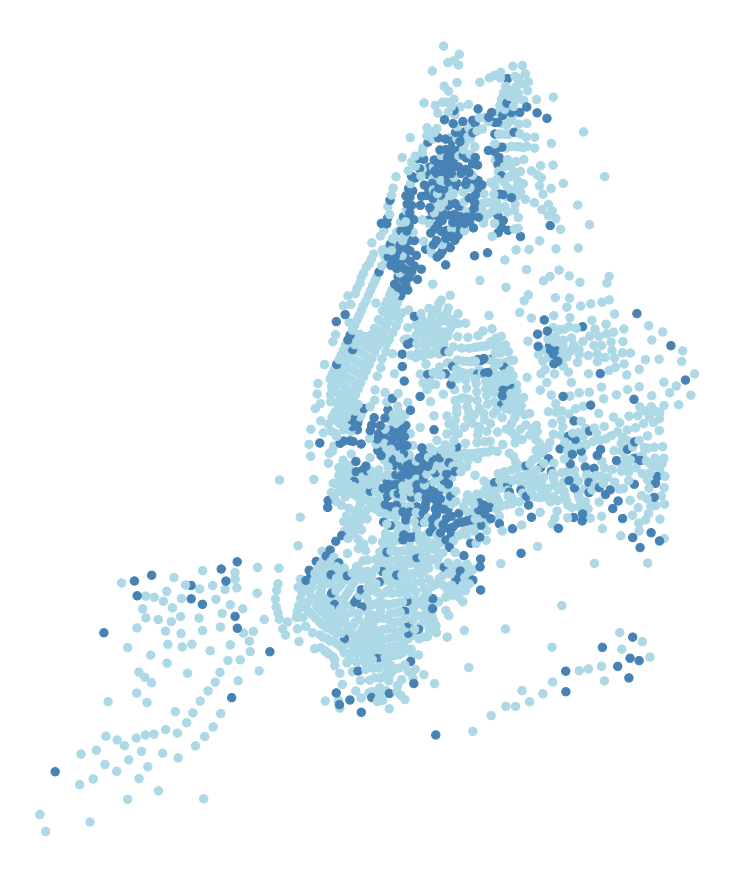

In [ ]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [ ]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [ ]:
hospital_locations = pd.read_csv('./datasets/nyc_hospitals.csv')['Location 1']
hospital_latlongs = [(latlong.split('\n')[2]).replace('(', '').replace(')', '').replace(' ', '').split(',') for latlong in list(hospital_locations)]

In [ ]:
hospitals = []
for h in hospital_latlongs:
    longitude = float(h[1])
    latitude = float(h[0])
    #if ((latitude > h_lat_s and latitude < h_lat_n) and
    #        (longitude > h_long_w and longitude < h_long_e)):
    hospitals.append([longitude, latitude, 0])

In [ ]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital[0], hospital[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    hospitals[i][2] = int(label)

In [ ]:
for i, values in enumerate(hospitals):
    n_long, n_lat, n_label = values
    city_graph.add_node(i,
                        pos=(n_long, n_lat))
    
    color_map.append('coral')

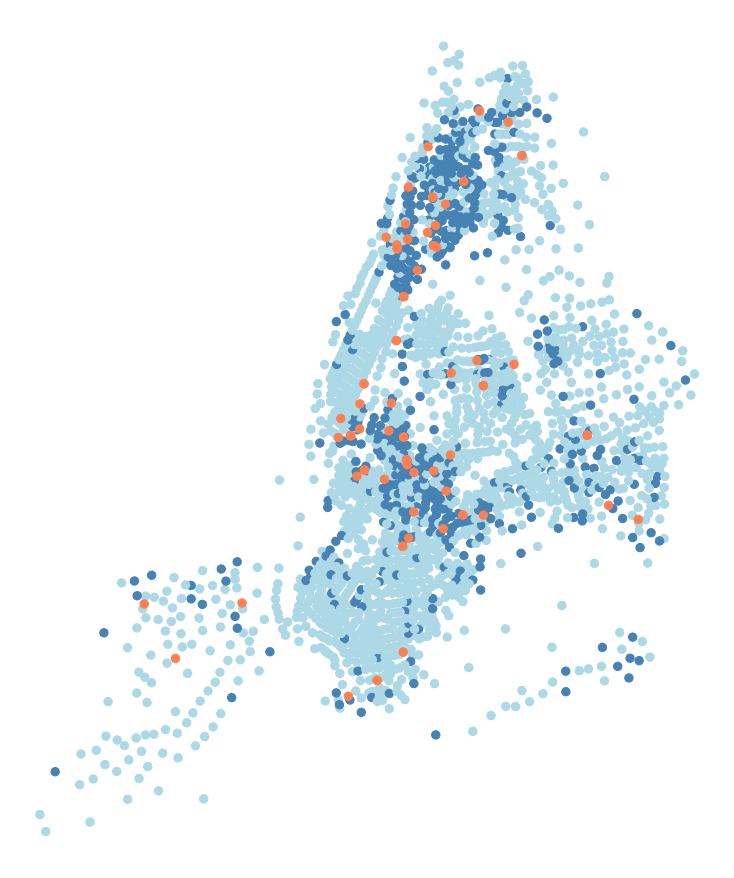

In [ ]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [ ]:
subway_locations = pd.read_csv('./datasets/nyc_subway.csv')['the_geom']
subway_latlongs = [s.replace('POINT', '').replace('(', '').replace(')', '').split(' ')[1:3] for s in subway_locations]

In [ ]:
subway = []
for s in subway_latlongs:
    longitude = float(s[0])
    latitude = float(s[1])
    #if ((latitude > h_lat_s and latitude < h_lat_n) and
    #        (longitude > h_long_w and longitude < h_long_e)):
    subway.append([longitude, latitude, 0])

In [ ]:
for i, s in enumerate(subway):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    subway[i][2] = int(label)

In [ ]:
school_locations = pd.read_csv('./datasets/nyc_schools.csv')['Location 1']
school_latlongs = [latlong.split('\n')[1].replace('(', '').replace(')', '').replace(' ', '').split(',') for latlong in school_locations[school_locations.notnull()]]

In [ ]:
schools = []
for s in school_latlongs:
    longitude = float(s[1])
    latitude = float(s[0])
    # if ((latitude > nyc_lat_s and latitude < nyc_lat_n) and
    #         (longitude > nyc_long_w and longitude < nyc_long_e)):
    schools.append([longitude, latitude, 0])

In [ ]:
for i, s in enumerate(schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    schools[i][2] = int(label)

In [ ]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [ ]:
# Remove the components you are interested in seeing
all_nodes = list(zip(tract_longs, tract_lats, tract_labels)) + hospitals + subway + schools

In [ ]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
subway_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(subway)))
school_indices = list(range(len(tracts) + len(hospitals) + len(subway), len(tracts) + len(hospitals) + len(subway) + len(schools)))

In [ ]:
len(hospitals), len(hospital_indices)

(78, 78)

In [ ]:
# Creating a graph using NetworkX

# Adding nodes
city_graph = nx.Graph()
color_map = []
for i, values in enumerate(all_nodes):
    n_long, n_lat, n_label = values

    city_graph.add_node(i, pos=(n_long, n_lat))

    if n_label == 1:
        color_map.append('steelblue')
    else:
        color_map.append('lightblue')

# Adding edges
# Each node is directly connected to its closest four neighbors
for i in all_indices:
    proximity_dict = {}
    for j in all_indices:
        if i != j:
            proximity_dict[j] = get_distance((all_nodes[i][0], all_nodes[i][1]),
                                             (all_nodes[j][0], all_nodes[j][1]))
    
    closest4 = sorted(proximity_dict, key=proximity_dict.get, reverse=False)[0:4]
    
    for neighbor in closest4:
        s_lat = all_nodes[neighbor][1]
        s_long = all_nodes[neighbor][0]
        distance = get_distance((all_nodes[i][0], all_nodes[i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(i, neighbor, weight=distance)


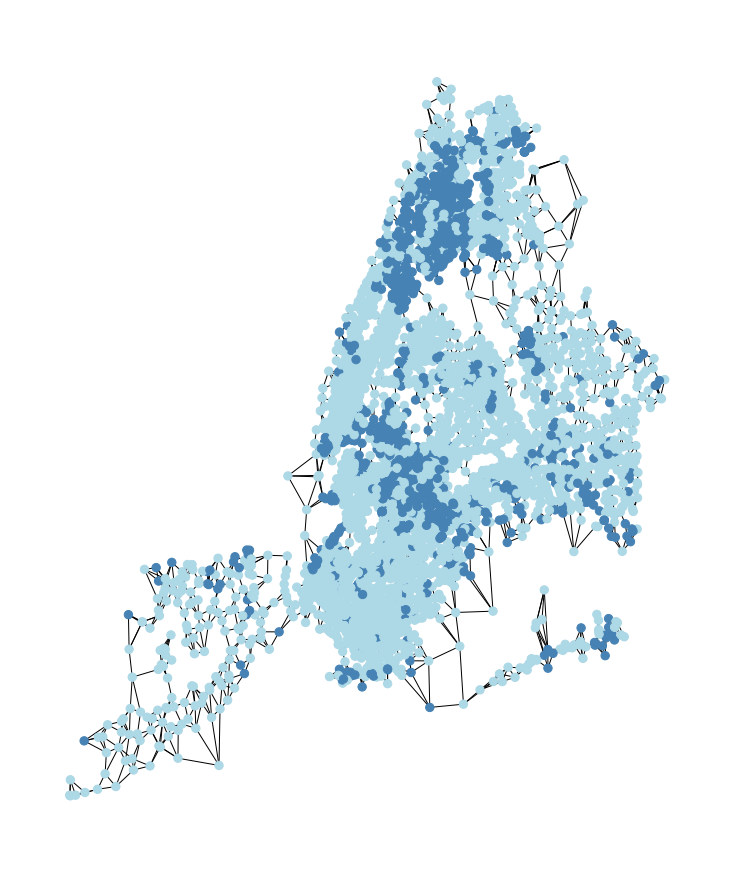

In [ ]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [ ]:
tracts

,id,lat,long,label
0,14000US36005000100,40.792936,-73.881207,0
1,14000US36005000200,40.803534,-73.860661,0
2,14000US36005000400,40.808787,-73.851425,0
3,14000US36005001600,40.818848,-73.858076,1
4,14000US36005001900,40.800999,-73.909373,1
...,...,...,...,...
2160,14000US36085030302,40.623529,-74.158743,0
2161,14000US36085031901,40.630303,-74.163321,1
2162,14000US36085031902,40.637921,-74.165570,1
2163,14000US36085032300,40.636927,-74.176144,0


In [ ]:
nx.shortest_path_length(city_graph, source=tract_indices[10], target=hospital_indices[10])

22

In [ ]:
hospital_paths = {}

for tract in tract_indices:
    hospitals_dict = {}
    for hospital in hospital_indices:
        if nx.has_path(city_graph, source=tract, target=hospital):
            hospitals_dict[hospital] = nx.shortest_path_length(city_graph,
                                                               source=tract,
                                                               target=hospital)
        else:
            hospitals_dict[hospital] = 100000
        
    closest2 = sorted(hospitals_dict, key=hospitals_dict.get, reverse=False)[0:2]

    hospital_paths[tract] = {"id":tracts.iloc[tract]['id'], "hospital_1":hospitals_dict[closest2[0]], "hospital_2":hospitals_dict[closest2[1]]}

In [ ]:
pd.DataFrame(hospital_paths).T

,id,hospital_1,hospital_2
0,14000US36005000100,6,7
1,14000US36005000200,7,8
2,14000US36005000400,8,9
3,14000US36005001600,9,10
4,14000US36005001900,6,6
...,...,...,...
2159,14000US36085030302,1,6
2160,14000US36085031901,1,6
2161,14000US36085031902,2,6
2162,14000US36085032300,2,7


In [ ]:
subway_paths = {}

for tract in tract_indices:
    subway_dict = {}
    for subway in subway_indices:
        if nx.has_path(city_graph, source=tract, target=subway):
            subway_dict[subway] = nx.shortest_path_length(city_graph,
                                                          source=tract,
                                                          target=subway)
        else:
            subway_dict[subway] = 100000
        
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]

    subway_paths[tract] = {"subway_1":subway_dict[closest2[0]], "subway_2":subway_dict[closest2[1]]}

In [ ]:
pd.DataFrame(subway_paths).T

,subway_1,subway_2
0,4,5
1,5,6
2,5,6
3,5,6
4,1,3
...,...,...
2159,17,19
2160,17,19
2161,17,19
2162,18,20


In [ ]:
school_paths = {}

for tract in tract_indices:
    schools_dict = {}
    for school in school_indices:
        if nx.has_path(city_graph, source=tract, target=school):
            schools_dict[school] = nx.shortest_path_length(city_graph,
                                                           source=tract,
                                                           target=school)
        else:
            schools_dict[school] = 100000
        
    closest2 = sorted(schools_dict, key=schools_dict.get, reverse=False)[0:2]

    school_paths[tract] = {"school_1":schools_dict[closest2[0]], "school_2":schools_dict[closest2[1]]}

    if tract % 300 == 0:
        print(tract)

0
300
600
900
1200
1500
1800
2100


In [ ]:
pd.DataFrame(school_paths).T

,school_1,school_2
0,2,2
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
2159,1,1
2160,1,2
2161,1,2
2162,1,1


In [ ]:
hospitals_df = pd.DataFrame(hospital_paths).T
subway_df = pd.DataFrame(subway_paths).T
schools_df = pd.DataFrame(school_paths).T

In [ ]:
poi_df = hospitals_df.join(subway_df).join(schools_df)

In [ ]:
poi_df

,id,hospital_1,hospital_2,subway_1,subway_2,school_1,school_2
0,14000US36005000100,6,7,4,5,2,2
1,14000US36005000200,7,8,5,6,1,1
2,14000US36005000400,8,9,5,6,1,1
3,14000US36005001600,9,10,5,6,1,1
4,14000US36005001900,6,6,1,3,1,1
...,...,...,...,...,...,...,...
2159,14000US36085030302,1,6,17,19,1,1
2160,14000US36085031901,1,6,17,19,1,2
2161,14000US36085031902,2,6,17,19,1,2
2162,14000US36085032300,2,7,18,20,1,1


In [ ]:
poi_df.to_csv("./datasets/nyc_shortest_paths", encoding='utf-8', index=False)